#Preprocessing Data
Shared Preprocessing for All Models

- Import original tweet dataset
- Define aspect keywords
- Extract aspect(s) per tweet
- Preprocess text (cleaning)

##1. Load Dataset

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import random
import html

# Set plot style
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Try specifying a different encoding if 'utf-8' is not working
try:
    df = pd.read_csv("Islamophobia2017-April2025.csv", encoding='utf-8')
except UnicodeDecodeError:
    print("UTF-8 encoding failed. Trying latin-1...")
    df = pd.read_csv("Islamophobia2017-April2025.csv", encoding='latin-1')


UTF-8 encoding failed. Trying latin-1...


In [ ]:
df.head()

,Id,created_at,full_text,label,type,explanation
0,1,Mon Jan 06 02:53:35 +0000 2025,Malaysia is a muslim country. They support Pal...,1,Fear-Mongering & Conspiracy,Frames Muslim refugees as violent and ungratef...
1,2,Sun Jan 05 18:41:56 +0000 2025,In Kerala a Hindu politician visiting a temple...,1,Religious Comparison,Highlights perceived bias favoring Muslim prac...
2,3,Thu Jan 16 02:46:43 +0000 2025,HUGE: Bangladesh Constitution Reform Commissio...,1,Fear-Mongering & Conspiracy,Predicts doom if Bangladesh adopts Islamic gov...
3,4,Mon Jan 06 03:22:36 +0000 2025,Malaysia allowed Palestinian refugees in their...,1,Fear-Mongering & Conspiracy,Suggests that helping Muslim refugees leads to...
4,5,Sat Jan 25 01:10:54 +0000 2025,Orang Melayu memang kuat bertoleransi tapi buk...,1,Cultural Resistance to Islamization,Claims excessive religious provocation and war...


In [ ]:
df.shape

(1535, 6)

####Count frequent word

In [ ]:
from collections import Counter

# Step 1: Tokenize all cleaned words from the dataset
all_tokens = [word for review in df['full_text'] for word in review.split()]

# Step 2: Count word frequency
word_freq = Counter(all_tokens)

# Step 3: Convert to DataFrame and display top N words
top_n = 50  # Change this number to show more/less
top_words_df = pd.DataFrame(word_freq.most_common(top_n), columns=['word', 'count'])

In [ ]:
print(top_words_df)

##2. Pre Processing Data
2.1 Translate

2.2 Clean Text

###2.1 Translate (Use Google Translate API)

In [ ]:
!pip install deep-translator langdetect

In [ ]:
from deep_translator import GoogleTranslator
from langdetect import detect
import time

# store translations to avoid duplicates
translation_cache = {}

# Translate from Malay to English
def translate_text(text):
    text = str(text)
    if text in translation_cache:
        return translation_cache[text]

    try:
        lang = detect(text)
        if lang != 'en':  # translate anything that's not already English
            translated = GoogleTranslator(source='auto', target='en').translate(text)
        else:
            translated = text
        translation_cache[text] = translated
        time.sleep(0.5)  # safer wait to avoid ban
        return translated
    except Exception as e:
        print(f"Translation failed: {text[:60]}... | Error: {e}")
        return text


In [ ]:
#apply translated to original text
df['translated_text'] = df['full_text'].astype(str).apply(translate_text)

In [ ]:
# Reorder columns to put translated_text right after full_text
cols = list(df.columns)
full_text_index = cols.index('full_text')
cols.insert(full_text_index + 1, cols.pop(cols.index('translated_text')))
df = df[cols]


In [ ]:
df[['Id','full_text','translated_text']].head(10)

,Id,full_text,translated_text
0,1,Malaysia is a muslim country. They support Pal...,Malaysia is a muslim country. They support Pal...
1,2,In Kerala a Hindu politician visiting a temple...,In Kerala a Hindu politician visiting a temple...
2,3,HUGE: Bangladesh Constitution Reform Commissio...,HUGE: Bangladesh Constitution Reform Commissio...
3,4,Malaysia allowed Palestinian refugees in their...,Malaysia allowed Palestinian refugees in their...
4,5,Orang Melayu memang kuat bertoleransi tapi buk...,The Malays are strongly tolerant but not a tic...
5,6,Wanna know why penunggang agamas are scared of...,Wanna know why penunggang agamas are scared of...
6,7,Quick history lesson: Malaysia rejected the me...,Quick history lesson: Malaysia rejected the me...
7,8,MCA nampaknya menanam sentimen kebencian terha...,The MCA seems to cultivate hatred for the Mala...
8,9,Islam semakin terancamâ¼ï¸ Kini Melayu sudah...,Islam is increasingly threatened by the Malays...
9,10,Bagus la kuil dan gereja di promosi...masjid k...,It's good for the temples and churches in the ...


In [ ]:
# Save to CSV or Excel
df.to_csv('translated_dataset.csv', index=False)

In [ ]:
df.shape

(1535, 8)

###2.2. Clean text
- URL removal
- Mention removal (@user)
- Hashtag removal (#topic)
- Stopword removal
- Punctuation/digits cleanup
- Convert weird characters to closest ASCII

In [ ]:
!pip install unidecode

In [ ]:
translate_df = pd.read_csv('translated_dataset.csv')

In [ ]:
from unidecode import unidecode
import re

def clean_text(text):
    text = str(text)
    text = text.replace("&amp;", "and")  # replace HTML ampersand
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # remove @mentions and hashtags
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = unidecode(text)  # normalize unicode to ASCII
    text = text.lower().strip()
    return text

# Apply it to your translated column
translate_df['cleaned_text'] = translate_df['translated_text'].apply(clean_text)


In [ ]:
translate_df[['Id','translated_text','cleaned_text']].head(20)

,Id,translated_text,cleaned_text
0,1,Malaysia is a muslim country. They support Pal...,malaysia is a muslim country they support pale...
1,2,In Kerala a Hindu politician visiting a temple...,in kerala a hindu politician visiting a temple...
2,3,HUGE: Bangladesh Constitution Reform Commissio...,huge bangladesh constitution reform commission...
3,4,Malaysia allowed Palestinian refugees in their...,malaysia allowed palestinian refugees in their...
4,5,The Malays are strongly tolerant but not a tic...,the malays are strongly tolerant but not a tic...
5,6,Wanna know why penunggang agamas are scared of...,wanna know why penunggang agamas are scared of...
6,7,Quick history lesson: Malaysia rejected the me...,quick history lesson malaysia rejected the mer...
7,8,The MCA seems to cultivate hatred for the Mala...,the mca seems to cultivate hatred for the mala...
8,9,Islam is increasingly threatened by the Malays...,islam is increasingly threatened by the malays...
9,10,It's good for the temples and churches in the ...,its good for the temples and churches in the p...


In [ ]:
# Save to CSV or Excel
translate_df.to_csv('cleaned_dataset.csv', index=False)

##3. Define Aspect & Keyword

In [ ]:
import pandas as pd
import re

# Finalized aspect keywords dictionary
aspect_keywords = {
    "Islamic Identity": ["hijab", "halal", "muslim", "mosque", "masjid", "prayer", "jilbab", "ummah", "azan", "islamic", "islam", "muslims", "imam", "haram", "quran"],
    "Secularism": ["secular", "secularisme", "liberal", "freedom", "lgbt", "gender rights", "modern", "democracy", "atheist", "women right"],
    "Religious Beliefs": ["islam teaches", "faith", "religious", "sharia law", "syariah", "terrorist", "violence", "oppression", "radical", "jihad", "fundamentalist", "extremist", "agama", "ceramah", "hukum", "hudud", "rejam"],
    "Institutions": ["jakim", "jawi", "religious school", "religious institution", "mufti", "ulama"],
    "Race": ["malay", "melayu", "chinese", "cina", "india", "indian", "racist", "racism", "race", "ethnic", "majority", "minority", "bumiputera"],
    "National Identity": ["malaysian", "malaysia", "patriot", "true malaysian", "bangsa", "identity", "malay supremacy", "ethnic", "negara"],
    "Politics": ["umno", "pas", "ph", "pn", "pm", "pmx", "bn", "dap", "mca", "pakatan", "hadi awang", "kit siang", "anwar", "politic", "government", "election", "mahathir", "najib"],
    "Social Issues": ["school", "student", "women", "gender", "feminist", "education", "morality", "sis", "human rights", "university", "curriculum", "media", "social", "campaign"],
    "Violence": ["extremist", "terrorist", "bomb", "radical", "militant", "threat", "security threat", "attack", "violence"]
}


In [ ]:
import re

    # Function to extract aspect(s) from a tweet
def extract_aspects(text):
    found_aspects = set()
    text = str(text).lower()
    for aspect, keywords in aspect_keywords.items():
        for keyword in keywords:
            if re.search(rf"\b{re.escape(keyword)}\b", text):
                found_aspects.add(aspect)
                break  # avoid duplicate checks
    return list(found_aspects) if found_aspects else ["None"]


Extract aspects per tweet

In [ ]:
# Aspect detection
aspect_data = []
skipped_data = []

for idx, row in translate_df.iterrows():
    tweet = row["cleaned_text"]
    tweet_id = row["Id"] if "Id" in translate_df.columns else idx
    matched = False

    for aspect, keywords in aspect_keywords.items():
        if any(keyword in tweet for keyword in keywords):
            aspect_data.append({
                "Id": tweet_id,
                "full_text": row["full_text"],
                "cleaned_text": tweet,
                "aspect": aspect
            })
            matched = True

    if not matched:
        skipped_data.append({
            "Id": tweet_id,
            "full_text": row["full_text"],
            "cleaned_text": tweet
        })

In [ ]:
# Create DataFrames
aspect_df = pd.DataFrame(aspect_data)
skipped_df = pd.DataFrame(skipped_data)

In [ ]:
aspect_df[['Id','cleaned_text', 'aspect']].head()

,Id,cleaned_text,aspect
0,1,malaysia is a muslim country they support palestine and hamas in august malaysia brought in people and their relatives from gaza for medical treatment these people are now rioting and vandalizing a hotel in kuala lumpur,Islamic Identity
1,1,malaysia is a muslim country they support palestine and hamas in august malaysia brought in people and their relatives from gaza for medical treatment these people are now rioting and vandalizing a hotel in kuala lumpur,Race
2,1,malaysia is a muslim country they support palestine and hamas in august malaysia brought in people and their relatives from gaza for medical treatment these people are now rioting and vandalizing a hotel in kuala lumpur,National Identity
3,2,in kerala a hindu politician visiting a temple or wearing a sacred thread is instantly branded as communal yet when cm pinarayi vijayans soninlaw minister riyaz visits mosques or markaz he s hailed as the epitome of secularism this shameless hypocrisy lays bare the,Islamic Identity
4,2,in kerala a hindu politician visiting a temple or wearing a sacred thread is instantly branded as communal yet when cm pinarayi vijayans soninlaw minister riyaz visits mosques or markaz he s hailed as the epitome of secularism this shameless hypocrisy lays bare the,Secularism


In [ ]:
# Report counts
print(f"Total tweets in dataset: {len(df)}")
print(f"Tweets with aspect: {aspect_df['Id'].nunique()}")
print(f"Tweets with NO aspect found: {len(skipped_df)}")

Total tweets in dataset: 1535
Tweets with aspect: 1525
Tweets with NO aspect found: 10


In [ ]:
# Save as CSV
aspect_df.to_csv("Aspect_Islamophobia.csv", index=False)

In [ ]:
import pandas as pd

# Ensure the column displays full text
pd.set_option('display.max_colwidth', None)

# View full tweets with no aspect detected
skipped_df[['Id', 'cleaned_text']]


,Id,cleaned_text
0,86,mantab la minister people who are hard to live in kl want to buyrent a house slow temple silent land belonging to people can get free land ready for new temple sponsors
1,161,civil court mampossss are now considered a infidel court the police of the jpj customs immigration customs are implemented
2,301,underweight of the house of representatives
3,317,the wooden floor wooden building that is on the edge of the dharmasraya forest in west sumatras polite village was demolished because it was considered disturbing when other brothers had enjoyed independence in it turned out that there were still many indonesian people still colonized and not yet independent
4,491,because our country is not an officially declared hindu country its more like an islumic state unofficially because of the concept of sickularism
5,596,taman sri muda residents praise selangor govt for flood response fmtnews fmteng
6,639,worship activities become illegal activities according to this country police and army are unable to reduce intolerant residents who stop christian people why they cant be captured they hold skbm golput presidenunfadah
7,984,m kece was arrested for resting the religion of rev saifuddin source of all of this abdul somad
8,1314,doors are being closed to zakir as seven states melaka johor selangor penang kedah perlis and sarawak have decided to bar the controversial preacher from speaking in public karma has no menu you get serverd what you deserve
9,1369,allegations of christianization are sticking out in penang


In [ ]:
aspect_df.isnull().sum()

,0
Id,0
full_text,0
cleaned_text,0
aspect,0


In [ ]:
aspect_df.shape

(5329, 4)

##Merged important features for analysis after define aspect and pre processing


In [ ]:
# Load your original full dataset (with all 7 columns)
try:
    original_df = pd.read_csv("Islamophobia2017-April2025.csv", encoding='utf-8')
except UnicodeDecodeError:
    print("UTF-8 encoding failed for original_df. Trying latin-1...")
    original_df = pd.read_csv("Islamophobia2017-April2025.csv", encoding='latin-1')


# Load the preprocessed aspect-matched data
aspect_df = pd.read_csv("Aspect_Islamophobia.csv")

# Merge on Id to get created_at and type
merged_df = aspect_df.merge(original_df[['Id', 'created_at', 'type']], on='Id', how='left')

# Reorder and select final columns
final_df = merged_df[['Id', 'created_at', 'cleaned_text', 'type', 'aspect']]

UTF-8 encoding failed for original_df. Trying latin-1...


In [ ]:
final_df.head(10)

,Id,created_at,cleaned_text,type,aspect
0,1,Mon Jan 06 02:53:35 +0000 2025,malaysia is a muslim country they support palestine and hamas in august malaysia brought in people and their relatives from gaza for medical treatment these people are now rioting and vandalizing a hotel in kuala lumpur,Fear-Mongering & Conspiracy,Islamic Identity
1,1,Mon Jan 06 02:53:35 +0000 2025,malaysia is a muslim country they support palestine and hamas in august malaysia brought in people and their relatives from gaza for medical treatment these people are now rioting and vandalizing a hotel in kuala lumpur,Fear-Mongering & Conspiracy,Race
2,1,Mon Jan 06 02:53:35 +0000 2025,malaysia is a muslim country they support palestine and hamas in august malaysia brought in people and their relatives from gaza for medical treatment these people are now rioting and vandalizing a hotel in kuala lumpur,Fear-Mongering & Conspiracy,National Identity
3,2,Sun Jan 05 18:41:56 +0000 2025,in kerala a hindu politician visiting a temple or wearing a sacred thread is instantly branded as communal yet when cm pinarayi vijayans soninlaw minister riyaz visits mosques or markaz he s hailed as the epitome of secularism this shameless hypocrisy lays bare the,Religious Comparison,Islamic Identity
4,2,Sun Jan 05 18:41:56 +0000 2025,in kerala a hindu politician visiting a temple or wearing a sacred thread is instantly branded as communal yet when cm pinarayi vijayans soninlaw minister riyaz visits mosques or markaz he s hailed as the epitome of secularism this shameless hypocrisy lays bare the,Religious Comparison,Secularism
5,2,Sun Jan 05 18:41:56 +0000 2025,in kerala a hindu politician visiting a temple or wearing a sacred thread is instantly branded as communal yet when cm pinarayi vijayans soninlaw minister riyaz visits mosques or markaz he s hailed as the epitome of secularism this shameless hypocrisy lays bare the,Religious Comparison,Politics
6,3,Thu Jan 16 02:46:43 +0000 2025,huge bangladesh constitution reform commission recommends to get rid of secularism mohd yunus adm will soon approve islamic republic of bangladesh socialism and nationalism to also get scrapped hindus of our country must wake up else the writing is on the wall,Fear-Mongering & Conspiracy,Islamic Identity
7,3,Thu Jan 16 02:46:43 +0000 2025,huge bangladesh constitution reform commission recommends to get rid of secularism mohd yunus adm will soon approve islamic republic of bangladesh socialism and nationalism to also get scrapped hindus of our country must wake up else the writing is on the wall,Fear-Mongering & Conspiracy,Secularism
8,3,Thu Jan 16 02:46:43 +0000 2025,huge bangladesh constitution reform commission recommends to get rid of secularism mohd yunus adm will soon approve islamic republic of bangladesh socialism and nationalism to also get scrapped hindus of our country must wake up else the writing is on the wall,Fear-Mongering & Conspiracy,Social Issues
9,4,Mon Jan 06 03:22:36 +0000 2025,malaysia allowed palestinian refugees in their country now the same refugees have started violence there not to forget malaysia is a muslim majority country and yet this giving these people shelter is the same as digging your own grave,Fear-Mongering & Conspiracy,Islamic Identity


In [ ]:
# Save to CSV
final_df.to_csv("ASPECT_preprocessed.csv", index=False)

# Optional: show dimensions
print(f" Final shape: {final_df.shape}")

 Final shape: (5329, 5)


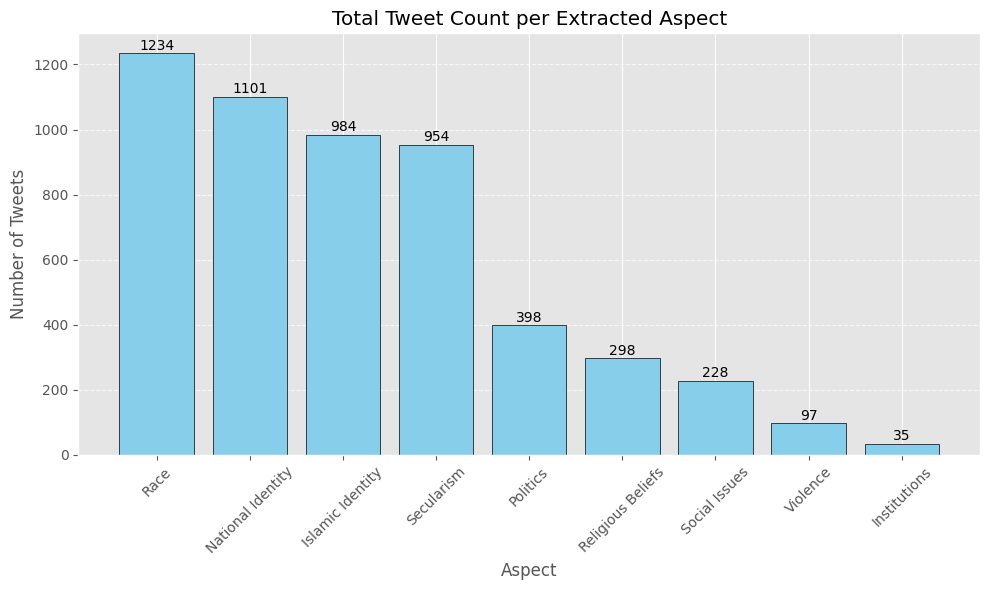

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Explode multi-aspect lists into separate rows
# Use final_df which contains the 'aspect' column
df_exploded = final_df.explode('aspect')

# Count aspects
aspect_counts = df_exploded['aspect'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(aspect_counts.index, aspect_counts.values, color='skyblue', edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.title("Total Tweet Count per Extracted Aspect")
plt.xlabel("Aspect")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()